## TVAE 모듈 이용하기 - 오류남

In [ ]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Usi

In [ ]:
!pip install --upgrade sdv

In [ ]:
!pip show sdv

Name: sdv
Version: 1.15.0
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: 
Author: 
Author-email: "DataCebo, Inc." <info@sdv.dev>
License: BSL-1.1
Location: /usr/local/lib/python3.10/dist-packages
Requires: boto3, botocore, cloudpickle, copulas, ctgan, deepecho, graphviz, numpy, pandas, platformdirs, pyyaml, rdt, sdmetrics, tqdm
Required-by: 


In [ ]:
from sdv.tabular import TVAE
from ctgan import load_demo

ModuleNotFoundError: No module named 'sdv.tabular'

In [ ]:
# "Adult Income Dataset"
real_data = load_demo()

# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

tvae =  TVAE(epochs=10)
tvae.fit(real_data, discrete_columns)

# Create synthetic data
synthetic_data = tvae.sample(1000)

In [ ]:
import pandas as pd

# 합성 데이터를 판다스 DataFrame으로 변환
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# 합성된 데이터의 일부를 출력
print(synthetic_df.head(10))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## TVAE 구현하기

1.csv, tsv 파일로 읽고 저장하기

In [1]:
import json

import numpy as np
import pandas as pd


def read_csv(csv_filename, meta_filename=None, header=True, discrete=None):
    """Read a csv file."""
    data = pd.read_csv(csv_filename, header='infer' if header else None)

    if meta_filename:
        with open(meta_filename) as meta_file:
            metadata = json.load(meta_file)

        discrete_columns = [
            column['name'] for column in metadata['columns'] if column['type'] != 'continuous'
        ]

    elif discrete:
        discrete_columns = discrete.split(',')
        if not header:
            discrete_columns = [int(i) for i in discrete_columns]

    else:
        discrete_columns = []

    return data, discrete_columns


def read_tsv(data_filename, meta_filename):
    """Read a tsv file."""
    with open(meta_filename) as f:
        column_info = f.readlines()

    column_info_raw = [x.replace('{', ' ').replace('}', ' ').split() for x in column_info]

    discrete = []
    continuous = []
    column_info = []

    for idx, item in enumerate(column_info_raw):
        if item[0] == 'C':
            continuous.append(idx)
            column_info.append((float(item[1]), float(item[2])))
        else:
            assert item[0] == 'D'
            discrete.append(idx)
            column_info.append(item[1:])

    meta = {
        'continuous_columns': continuous,
        'discrete_columns': discrete,
        'column_info': column_info,
    }

    with open(data_filename) as f:
        lines = f.readlines()

    data = []
    for row in lines:
        row_raw = row.split()
        row = []
        for idx, col in enumerate(row_raw):
            if idx in continuous:
                row.append(col)
            else:
                assert idx in discrete
                row.append(column_info[idx].index(col))

        data.append(row)

    return np.asarray(data, dtype='float32'), meta['discrete_columns']


def write_tsv(data, meta, output_filename):
    """Write to a tsv file."""
    with open(output_filename, 'w') as f:
        for row in data:
            for idx, col in enumerate(row):
                if idx in meta['continuous_columns']:
                    print(col, end=' ', file=f)
                else:
                    assert idx in meta['discrete_columns']
                    print(meta['column_info'][idx][int(col)], end=' ', file=f)

            print(file=f)

2.data transformer : 데이터셋의 이산형 및 연속형 열을 각각 적절한 방식으로 변환하고, 이를 모델 학습에 사용할 수 있도록 변환된 데이터를 제공하는 역할 &  변환된 데이터를 원래 형태로 복원하는 기능도 제공

In [2]:
!pip install rdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 789.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.3 MB/s eta 0:00:00


In [4]:
from collections import namedtuple

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder

SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo',
    ['column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'],
)


class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold,
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='continuous',
            transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components,
        )

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='discrete',
            transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories,
        )

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data, self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(raw_data, self._column_transform_info_list)

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes())).astype(float)
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st : st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st
                )
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data
                )

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = pd.DataFrame(recovered_data, columns=column_names).astype(
            self._column_raw_dtypes
        )
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot),
        }

3.base class : 랜덤 상태 관리, 객체의 직렬화 및 역직렬화, 모델 저장 및 불러오기 등의 기능을 제공

In [5]:
import contextlib

import numpy as np
import torch


@contextlib.contextmanager
def set_random_states(random_state, set_model_random_state):
    """Context manager for managing the random state.

    Args:
        random_state (int or tuple):
            The random seed or a tuple of (numpy.random.RandomState, torch.Generator).
        set_model_random_state (function):
            Function to set the random state on the model.
    """
    original_np_state = np.random.get_state()
    original_torch_state = torch.get_rng_state()

    random_np_state, random_torch_state = random_state

    np.random.set_state(random_np_state.get_state())
    torch.set_rng_state(random_torch_state.get_state())

    try:
        yield
    finally:
        current_np_state = np.random.RandomState()
        current_np_state.set_state(np.random.get_state())
        current_torch_state = torch.Generator()
        current_torch_state.set_state(torch.get_rng_state())
        set_model_random_state((current_np_state, current_torch_state))

        np.random.set_state(original_np_state)
        torch.set_rng_state(original_torch_state)


def random_state(function):
    """Set the random state before calling the function.

    Args:
        function (Callable):
            The function to wrap around.
    """

    def wrapper(self, *args, **kwargs):
        if self.random_states is None:
            return function(self, *args, **kwargs)

        else:
            with set_random_states(self.random_states, self.set_random_state):
                return function(self, *args, **kwargs)

    return wrapper


class BaseSynthesizer:
    """Base class for all default synthesizers of ``CTGAN``."""

    random_states = None

    def __getstate__(self):
        """Improve pickling state for ``BaseSynthesizer``.

        Convert to ``cpu`` device before starting the pickling process in order to be able to
        load the model even when used from an external tool such as ``SDV``. Also, if
        ``random_states`` are set, store their states as dictionaries rather than generators.

        Returns:
            dict:
                Python dict representing the object.
        """
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        state = self.__dict__.copy()
        self.set_device(device_backup)
        if (
            isinstance(self.random_states, tuple)
            and isinstance(self.random_states[0], np.random.RandomState)
            and isinstance(self.random_states[1], torch.Generator)
        ):
            state['_numpy_random_state'] = self.random_states[0].get_state()
            state['_torch_random_state'] = self.random_states[1].get_state()
            state.pop('random_states')

        return state

    def __setstate__(self, state):
        """Restore the state of a ``BaseSynthesizer``.

        Restore the ``random_states`` from the state dict if those are present and then
        set the device according to the current hardware.
        """
        if '_numpy_random_state' in state and '_torch_random_state' in state:
            np_state = state.pop('_numpy_random_state')
            torch_state = state.pop('_torch_random_state')

            current_torch_state = torch.Generator()
            current_torch_state.set_state(torch_state)

            current_numpy_state = np.random.RandomState()
            current_numpy_state.set_state(np_state)
            state['random_states'] = (current_numpy_state, current_torch_state)

        self.__dict__ = state
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_device(device)

    def save(self, path):
        """Save the model in the passed `path`."""
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        torch.save(self, path)
        self.set_device(device_backup)

    @classmethod
    def load(cls, path):
        """Load the model stored in the passed `path`."""
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load(path)
        model.set_device(device)
        return model

    def set_random_state(self, random_state):
        """Set the random state.

        Args:
            random_state (int, tuple, or None):
                Either a tuple containing the (numpy.random.RandomState, torch.Generator)
                or an int representing the random seed to use for both random states.
        """
        if random_state is None:
            self.random_states = random_state
        elif isinstance(random_state, int):
            self.random_states = (
                np.random.RandomState(seed=random_state),
                torch.Generator().manual_seed(random_state),
            )
        elif (
            isinstance(random_state, tuple)
            and isinstance(random_state[0], np.random.RandomState)
            and isinstance(random_state[1], torch.Generator)
        ):
            self.random_states = random_state
        else:
            raise TypeError(
                f'`random_state` {random_state} expected to be an int or a tuple of '
                '(`np.random.RandomState`, `torch.Generator`)'
            )

4.TVAE 구현하기

In [8]:
import numpy as np
import pandas as pd
import torch
import time
from torch.nn import Linear, Module, Parameter, ReLU, Sequential
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


class Encoder(Module):
    """Encoder for the TVAE.

    Args:
        data_dim (int): Dimensions of the data.
        compress_dims (tuple or list of ints): Size of each hidden layer.
        embedding_dim (int): Size of the output vector.
    """

    def __init__(self, data_dim, compress_dims, embedding_dim):
        super(Encoder, self).__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, embedding_dim)
        self.fc2 = Linear(dim, embedding_dim)

    def forward(self, input_):
        """Encode the passed input_."""
        feature = self.seq(input_)
        mu = self.fc1(feature) # 평균
        logvar = self.fc2(feature) # 표준편차 계산
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    """Decoder for the TVAE.

    Args:
        embedding_dim (int): Size of the input vector.
        decompress_dims (tuple or list of ints): Size of each hidden layer.
        data_dim (int): Dimensions of the data.
    """

    def __init__(self, embedding_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = embedding_dim # latent vector이 embedding_dim 차원
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1) # parameter 0.1 로 모두 초기화

    def forward(self, input_):
        """Decode the passed input_."""
        return self.seq(input_), self.sigma
def _loss_function(recon_x, x, sigmas, mu, logvar, output_info, factor):
    """
    Args:
        recon_x: decoder의 출력
        sgimas: 디코더의 출력을 나타내는 불확실성 파라미터
        mu: encoder의 출력, 평균
        logvar :encoder의 출력, 표준편
        output_info: 출력데이터의 구조 정보
    """
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax': # ex) 연속형인 경우
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st]) # 원본데이터와 생성데이터의 차이
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            # 범주형데이터인 경우
            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum' # cross entorpy
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp()) # KLD 계산
    return sum(loss) * factor / x.size()[0], KLD / x.size()[0] # reconstruction loss + KLD 계산


class TVAE(Module):
    """TVAE."""

    def __init__(
        self,
        embedding_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128),
        l2scale=1e-5,
        batch_size=500,
        epochs=300,
        loss_factor=2,
        cuda=True,
        verbose=False,
    ):
        super(TVAE, self).__init__()
        self.embedding_dim = embedding_dim
        self.compress_dims = compress_dims # encoder hidden layer
        self.decompress_dims = decompress_dims # decoder hidden layer

        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        self.verbose = verbose

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)


    def fit(self, train_data, discrete_columns=()):
        """Fit the TVAE Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame): Training Data.
                It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like): List of discrete columns to be used to generate
                the Conditional Vector. If train_data is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is a pandas.DataFrame,
                this list should contain the column names.
        """
        # 데이터 변환, 데이터 로더
        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        train_data = self.transformer.transform(train_data)
        dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)

        data_dim = self.transformer.output_dimensions
        encoder = Encoder(data_dim, self.compress_dims, self.embedding_dim).to(self._device)
        self.decoder = Decoder(self.embedding_dim, self.decompress_dims, data_dim).to(self._device)
        optimizerAE = Adam(
            list(encoder.parameters()) + list(self.decoder.parameters()), weight_decay=self.l2scale
        )


        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        iterator = tqdm(range(self.epochs), disable=(not self.verbose))
        if self.verbose:
            iterator_description = 'Epoch: {epoch}, Iter: {iter}, Total Loss: {loss:.3f}, Recon Loss: {recon_loss:.3f}, KLD Loss: {kld_loss:.3f}, Time: {time:.2f}s'
            iterator.set_description(iterator_description.format(epoch=0, iter=0, loss=0, recon_loss=0, kld_loss=0, time=0))

        for epoch in iterator:
            start_time = time.time()
            loss_values = []
            recon_loss_values = []
            kld_loss_values = []
            batch = []
            for id_, data in enumerate(loader):
                optimizerAE.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = encoder(real) # 평균, 표준편차, log분산
                eps = torch.randn_like(std) # 노이즈 random samolung
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb) # 재구성된 데이터, 불확실성
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                    self.loss_factor,
                )
                loss = loss_1 + loss_2
                loss.backward()
                optimizerAE.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)

                batch.append(id_)
                loss_values.append(loss.detach().cpu().item())
                recon_loss_values.append(loss_1.item())
                kld_loss_values.append(loss_2.item())

                if self.verbose:
                    elapsed_time = time.time() - start_time
                    iterator.set_description(
                        iterator_description.format(epoch=epoch + 1, iter=id_ + 1, loss=np.mean(loss_values), recon_loss=np.mean(recon_loss_values), kld_loss=np.mean(kld_loss_values), time=elapsed_time)
                    )

            epoch_loss_df = pd.DataFrame({
                'Epoch': [epoch] * len(batch),
                'Batch': batch,
                'Loss': loss_values,
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            elapsed_time = time.time() - start_time
            if self.verbose:
                iterator.set_description(
                    iterator_description.format(epoch=epoch + 1, iter=len(loader), loss=np.mean(loss_values), recon_loss=np.mean(recon_loss_values), kld_loss=np.mean(kld_loss_values), time=elapsed_time)
                )

            # 학습 과정 시각화
            print(f"Epoch [{epoch+1}/{self.epochs}], Total Loss: {np.mean(loss_values):.4f}, Recon Loss: {np.mean(recon_loss_values):.4f}, KLD Loss: {np.mean(kld_loss_values):.4f}, Time: {elapsed_time:.2f}s")


    def sample(self, samples):
        """Sample data similar to the training data.

        Args:
            samples (int): Number of rows to sample.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.embedding_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the device to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)

5.Train

In [9]:
epochs = 100
tsv = False
header = True
metadata = None
discrete = 'workclass,education,marital-status,occupation,relationship,race,sex,native-country,income'
num_samples = None
embedding_dim = 128
compress_dims = '128,128'
decompress_dims = '128,128'
batch_size = 500
save = None
load = None
sample_condition_column = None
sample_condition_column_value = None
data_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult.csv"  # 데이터 경로 설정
output_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_TVAE.csv"  # 출력 경로 설정

# 데이터 로드
if tsv:
    data, discrete_columns = read_tsv(data_path, metadata)
else:
    data, discrete_columns = read_csv(data_path, metadata, header, discrete)

# 모델 로드 또는 초기화
if load:
    model = TVAE.load(load)
else:
    compress_dims = [int(x) for x in compress_dims.split(',')]
    decompress_dims = [int(x) for x in decompress_dims.split(',')]
    model = TVAE(
        embedding_dim=embedding_dim,
        compress_dims=compress_dims,
        decompress_dims=decompress_dims,
        batch_size=batch_size,
        epochs=epochs,
    )

# 모델 학습
model.fit(data, discrete_columns)

# 모델 저장
if save is not None:
    model.save(save)

# 샘플링
num_samples = num_samples or len(data)

if sample_condition_column is not None:
    assert sample_condition_column_value is not None

sampled = model.sample(num_samples)

# 결과 저장
if tsv:
    write_tsv(sampled, metadata, output_path)
else:
    sampled.to_csv(output_path, index=False)

print(f"Sampled data saved to {output_path}")


Epoch [1/100], Total Loss: 33.1168, Recon Loss: 32.9495, KLD Loss: 0.1674, Time: 0.70s
Epoch [2/100], Total Loss: 21.4495, Recon Loss: 20.9877, KLD Loss: 0.4619, Time: 0.72s
Epoch [3/100], Total Loss: 20.1824, Recon Loss: 18.9591, KLD Loss: 1.2233, Time: 0.76s
Epoch [4/100], Total Loss: 19.8216, Recon Loss: 18.3589, KLD Loss: 1.4626, Time: 0.85s
Epoch [5/100], Total Loss: 18.3036, Recon Loss: 15.9736, KLD Loss: 2.3300, Time: 0.71s
Epoch [6/100], Total Loss: 17.4562, Recon Loss: 14.6442, KLD Loss: 2.8120, Time: 0.71s
Epoch [7/100], Total Loss: 16.5343, Recon Loss: 13.2122, KLD Loss: 3.3221, Time: 0.72s
Epoch [8/100], Total Loss: 15.6523, Recon Loss: 11.8068, KLD Loss: 3.8455, Time: 0.81s
Epoch [9/100], Total Loss: 14.5809, Recon Loss: 10.3819, KLD Loss: 4.1990, Time: 0.96s
Epoch [10/100], Total Loss: 13.1504, Recon Loss: 8.5848, KLD Loss: 4.5656, Time: 1.00s
Epoch [11/100], Total Loss: 11.9142, Recon Loss: 6.9074, KLD Loss: 5.0068, Time: 1.08s
Epoch [12/100], Total Loss: 11.1259, Recon 

6.잘 sample 됬는지 평가

- accuracy가 50% 에 가까울수록
- tp, tn이 높고 fp와 fn 이 낮을수록
- 정밀도와 재현율이 낮을수록
- roc auc score가 0.5이면


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.742341650671785
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      6513
           1       0.72      0.80      0.76      6512

    accuracy                           0.74     13025
   macro avg       0.75      0.74      0.74     13025
weighted avg       0.75      0.74      0.74     13025

Confusion Matrix:
[[4467 2046]
 [1310 5202]]
ROC AUC Score: 0.8023553158283698


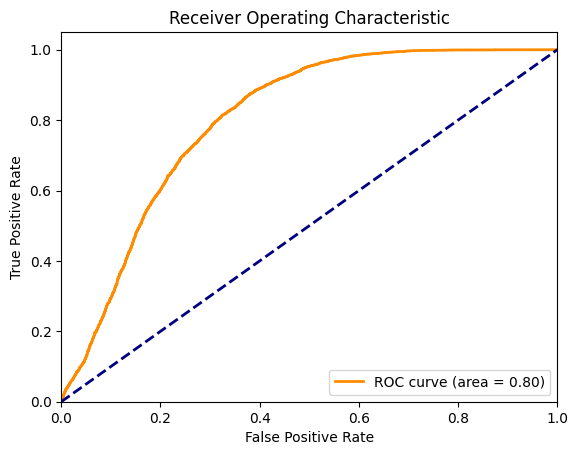

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 원본 데이터와 생성된 데이터 로드
original_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult.csv")
synthetic_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_TVAE.csv")

# 라벨 추가 (원본 데이터: 0, 생성된 데이터: 1)
original_data['label'] = 0
synthetic_data['label'] = 1

# 두 데이터셋 결합
combined_data = pd.concat([original_data, synthetic_data], ignore_index=True)

# 범주형 컬럼과 연속형 컬럼 구분
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
numerical_columns = [col for col in combined_data.columns if col not in categorical_columns and col != 'label']

def preprocess_data(df):
    # 원-핫 인코딩
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_categorical = encoder.fit_transform(df[categorical_columns])

    # 연속형 데이터 스케일링
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[numerical_columns])

    # 인코딩된 데이터와 스케일된 데이터 합치기
    X = np.hstack((encoded_categorical, scaled_numerical))
    y = df['label'].values

    return X, y

X, y = preprocess_data(combined_data)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 분류기 학습
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 결과 출력
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC Score: {roc_auc}')

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

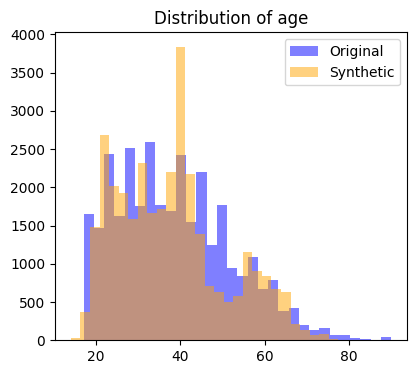

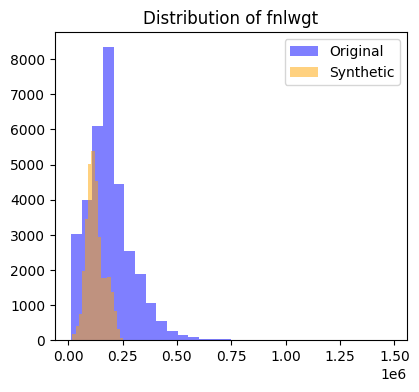

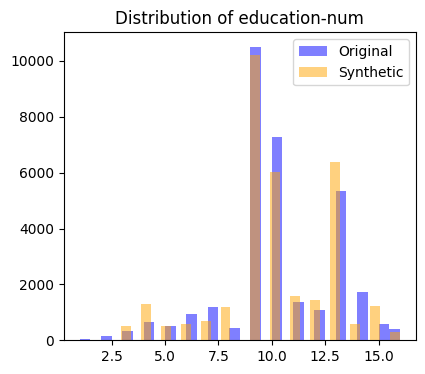

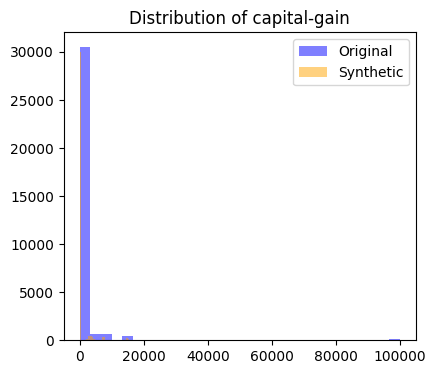

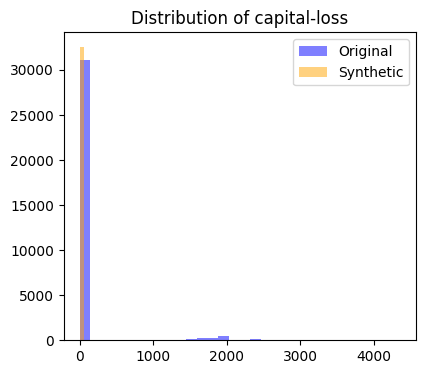

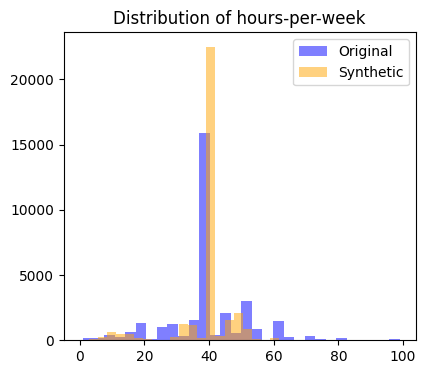

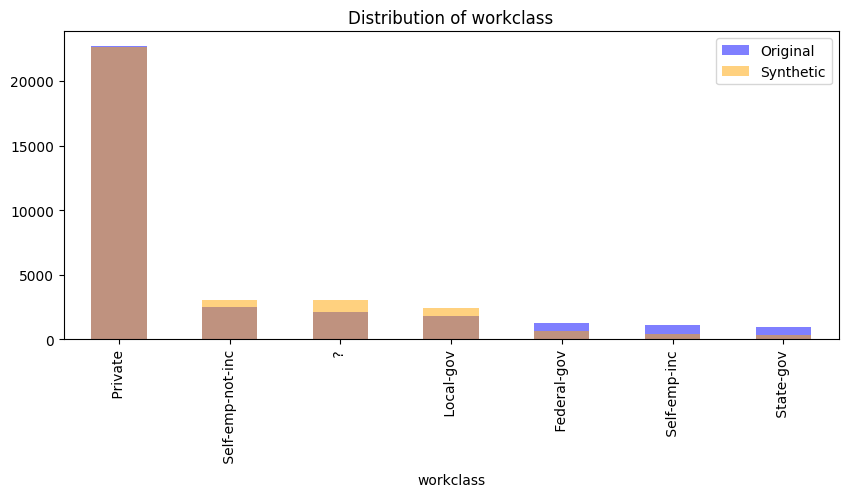

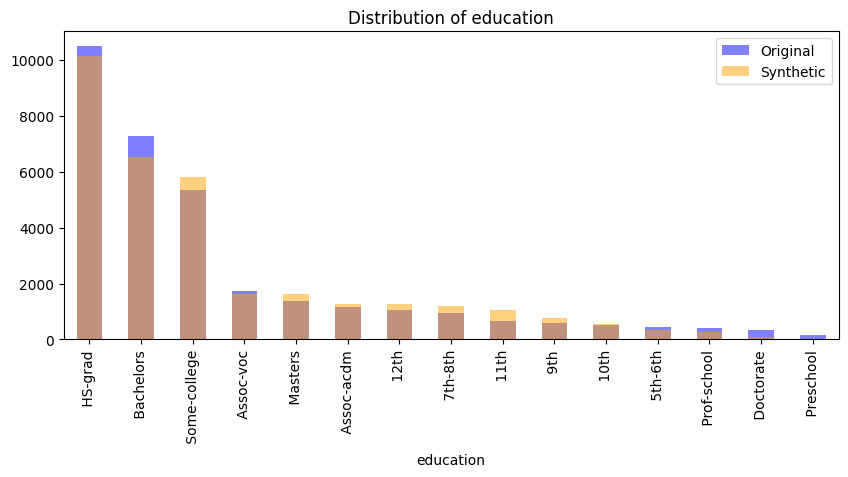

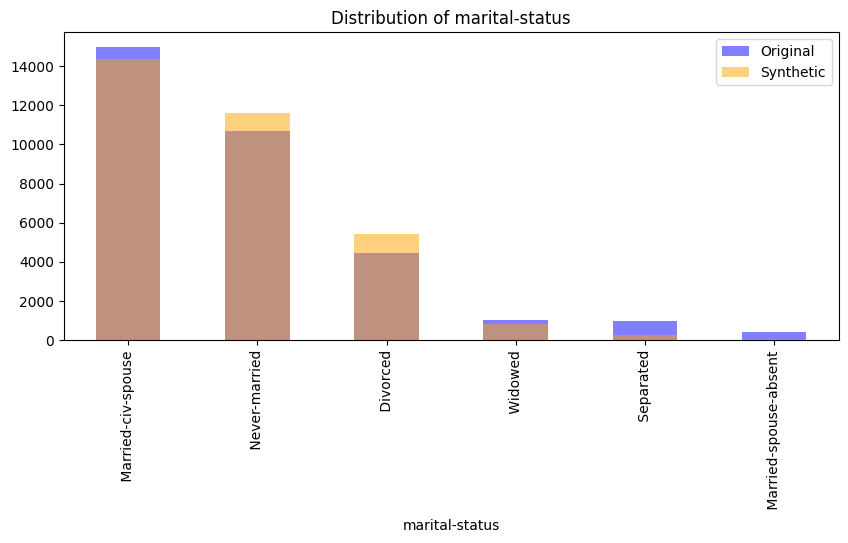

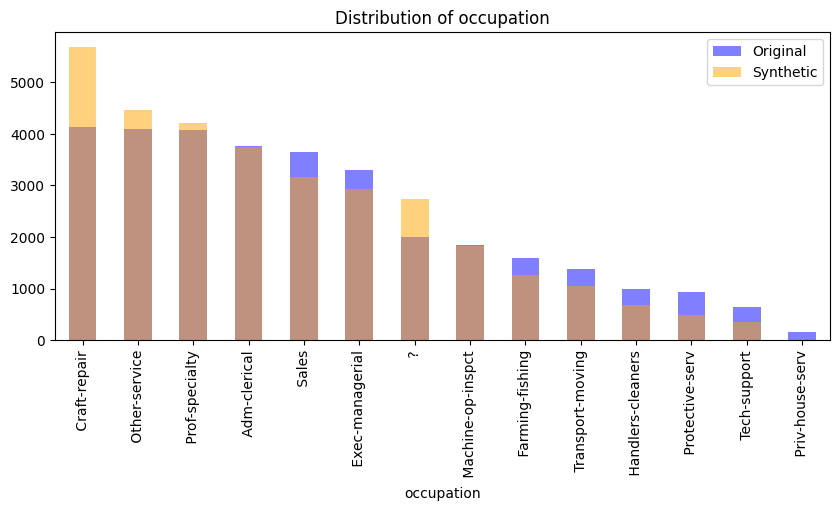

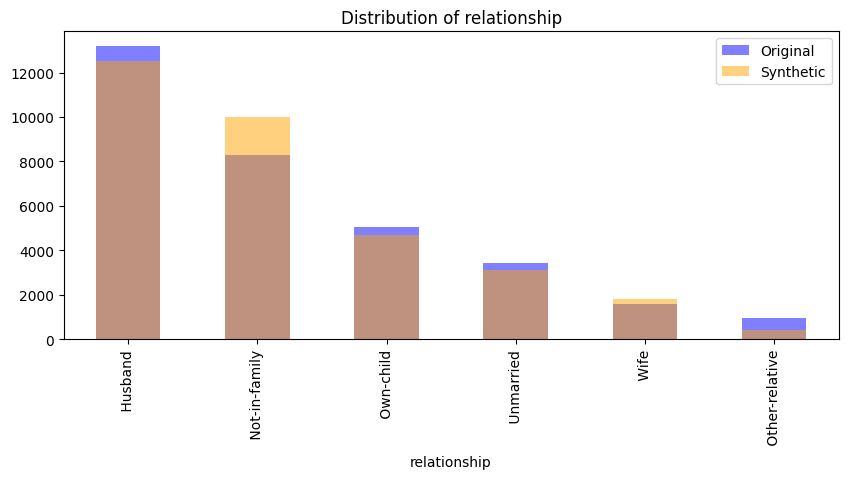

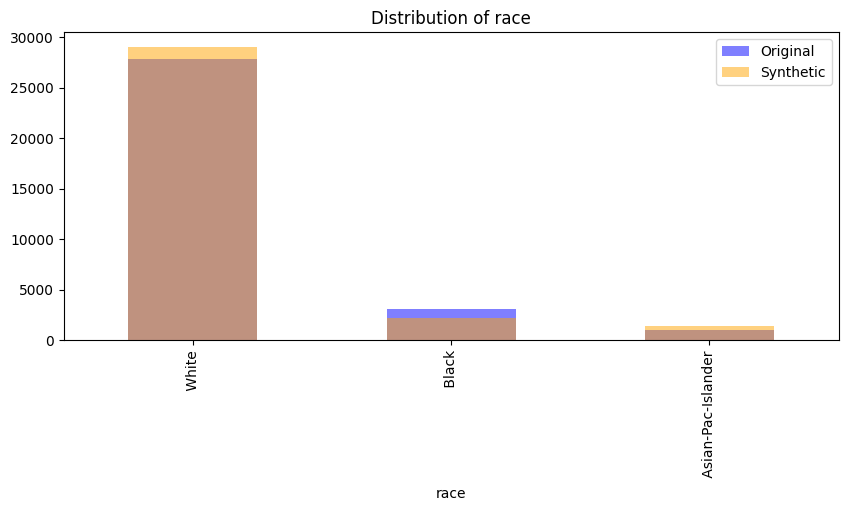

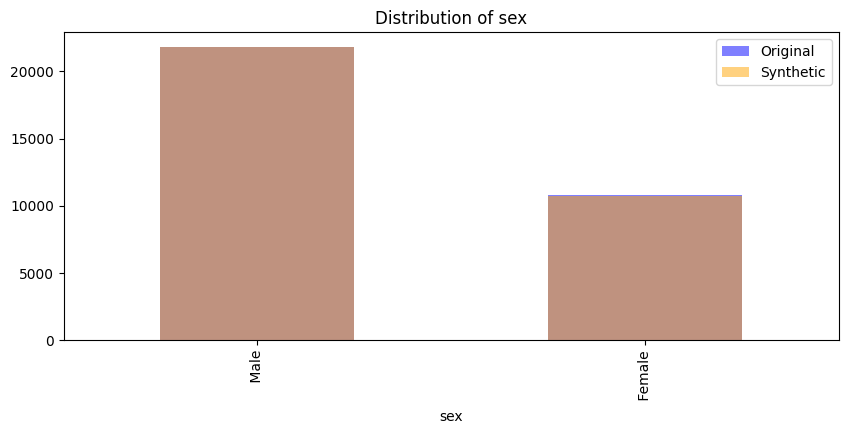

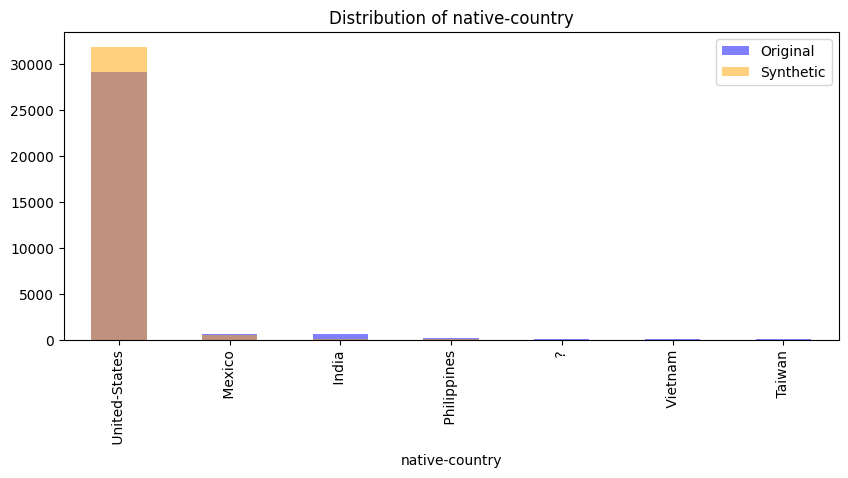

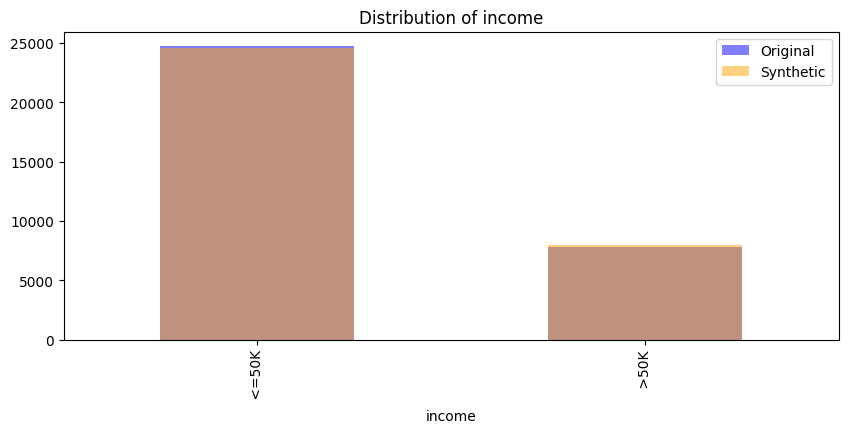

In [11]:
import matplotlib.pyplot as plt

# 데이터 분포 시각화
def plot_distributions(original, synthetic, columns, kind='hist'):
    for col in columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if kind == 'hist':
            plt.hist(original[col], bins=30, alpha=0.5, label='Original', color='blue')
            plt.hist(synthetic[col], bins=30, alpha=0.5, label='Synthetic', color='orange')
        elif kind == 'box':
            plt.boxplot([original[col], synthetic[col]], labels=['Original', 'Synthetic'])
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

# 연속형 데이터 분포 시각화
plot_distributions(original_data, synthetic_data, numerical_columns, kind='hist')

# 범주형 데이터 분포 시각화
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    original_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Original', color='blue')
    synthetic_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Synthetic', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()